In [3]:
# loading libraries
import pandas as pd
import numpy as np
from statistics import mean
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


## Reading data and dividing dependent and independent variables separately

In [4]:
# loading training data
df = pd.read_csv('HWdata.csv')
df.head()
X_df=df.drop('Lbl', axis=1)
X_df.head()

X = X_df
y = df['Lbl']

## Plotting data before normalization

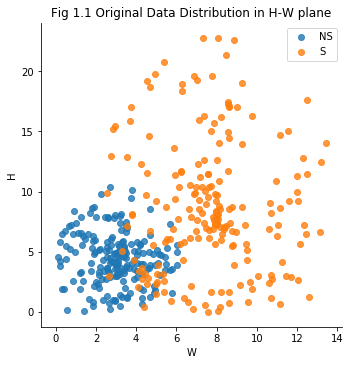

In [5]:
import seaborn as sns
sns.lmplot('W', 'H', df, hue='Lbl', fit_reg=False,legend=False)
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.legend()
plt.title('Fig 1.1 Original Data Distribution in H-W plane')
plt.show()

## Normalizing / Scaling the data to lie within range of (0,1)

In [6]:
X_df=(X-X.min())/(X.max()-X.min())

from sklearn.preprocessing import LabelEncoder
labelencoder_y=LabelEncoder()
y = labelencoder_y.fit_transform(y)

## Plotting data after normalization

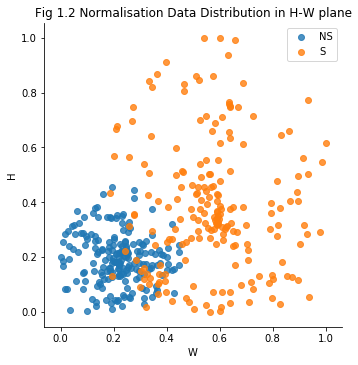

In [5]:
new_df=pd.DataFrame(X_df)
new_df['Lbl']=df['Lbl']
sns.lmplot('W', 'H', new_df, hue='Lbl', fit_reg=False,legend=False)
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.legend()
plt.title('Fig 1.2 Normalisation Data Distribution in H-W plane')
plt.show()

## Custom functions for implementing perceptron and function to find confusion matrix and metrics

In [6]:
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        activation += weights[i + 1] * row[i]
    return 1 if activation >= 0.0 else 0
 
def train_weights(x_train, y_train, l_rate, n_epoch):
    weights = [0.0 for i in range(len(x_train.columns)+1)]
    all_epoch_weights=[]
    all_predictions_train=[]
    for epoch in range(n_epoch):
        c=0
        predictions_train=[]
        for index, row in x_train.iterrows():
            prediction = predict(row, weights)
            error = y_train[c] - prediction
            c=c+1
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row)):
                weights[i + 1] = float(weights[i + 1]) + (l_rate * error * float(row[i]))
            predictions_train.append(prediction)
        w_c=weights.copy()
        p_t=predictions_train.copy()
        all_epoch_weights.append(w_c)
        all_predictions_train.append(p_t)
    val={'weights':all_epoch_weights,'train_pred':all_predictions_train}
    return val
 
def perceptronAlgo(x_train, x_test, y_train, l_rate, n_epoch):

    all_predictions_test=list()
    dict_resp = train_weights(x_train,y_train, l_rate, n_epoch)
    #print(dict_resp)
    for w in dict_resp['weights']:
        predictions_test = list()
        
        for index1, row1 in x_test.iterrows():
            prediction = predict(row1, w)
            predictions_test.append(prediction)
 
        all_predictions_test.append(predictions_test)
    #print(all_predictions_test)
    resp={'train_pred':dict_resp['train_pred'],'test_pred':all_predictions_test, 'weights':dict_resp['weights']}
    return resp

def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[int(exp)][pred] += 1
    return m

def hit_rate(con_mat):
    val=(con_mat[0][0] +con_mat[1][1])/ (con_mat[0][0] + con_mat[1][0] +con_mat[0][1]+con_mat[1][1])
    return val
def sensitivity(con_mat):
    if (con_mat[1][1] + con_mat[1][0])==0:
        return float('NaN')
    val=con_mat[1][1] / (con_mat[1][1] + con_mat[1][0] )
    return val
def specificity(con_mat):
    if (con_mat[0][0] + con_mat[0][1])==0:
        return float('NaN')
    val=con_mat[0][0] / (con_mat[0][1] + con_mat[0][0] )
    return val
def PPV(con_mat):
    if (con_mat[1][1] + con_mat[0][1])==0:
        return float('NaN')
    val=con_mat[1][1] / (con_mat[1][1] + con_mat[0][1] )
    return val
def NPV(con_mat):
    if (con_mat[0][0] + con_mat[1][0])==0:
        return float('NaN')
    val=con_mat[0][0] / (con_mat[1][0] + con_mat[0][0] )
    return val

## Splitting the data to train and test and calling training the perceptron with learning rate 0.01 and epoch=50

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=5)
perc_results=perceptronAlgo(X_train, X_test, y_train, 0.01, 50)

## Finding predictions before training starts with weights as [0,0,0]

In [11]:
weights_intial = [0.0 for i in range(len(X_train.columns)+1)]
pred_test_b4_wghtUpdt=[]
for index, row in X_test.iterrows():
    prediction = predict(row, weights_intial)
    pred_test_b4_wghtUpdt.append(prediction)
test_err_rate=[]
test_err_rate.append(1-hit_rate(create_conf_matrix(y_test,pred_test_b4_wghtUpdt,2)))

## Getting training error rate and Testing error rate for all epochs

In [12]:
train_err_rate=[]
for i in range(len(perc_results['test_pred'])):
    con_mat_train=create_conf_matrix(y_train,perc_results['train_pred'][i],2)
    train_err_rate.append(1-hit_rate(con_mat_train))
    con_mat_test=create_conf_matrix(y_test,perc_results['test_pred'][i],2)
    test_err_rate.append(1-hit_rate(con_mat_test))

## Finding predictions after training done for 50 epochs

In [13]:
weights_final = perc_results['weights'][49]
pred_train_final=[]
for index, row in X_train.iterrows():
    prediction = predict(row, weights_final)
    pred_train_final.append(prediction)
train_err_rate.append(1-hit_rate(create_conf_matrix(y_train,pred_train_final,2)))

## Plotting both error rates against epochs

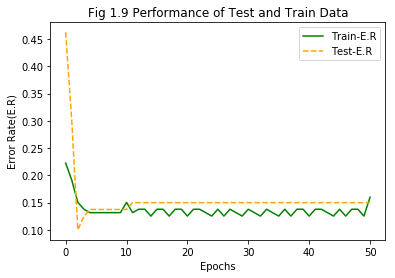

In [14]:
epoch = range(0,51)
plt.plot(epoch, train_err_rate, color='g', label='sine',linestyle='-')
plt.plot(epoch, test_err_rate, color='orange',label='cos',linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.gca().legend(('Train-E.R','Test-E.R'))
plt.title('Fig 1.9 Performance of Test and Train Data')
plt.show()

## Calculating  5 metrics for both test and train data

In [15]:
pred_test_final=[]
for index, row in X_test.iterrows():
    prediction = predict(row, weights_final)
    pred_test_final.append(prediction)

train_conf_mat_final=create_conf_matrix(y_train,pred_train_final,2)
test_conf_mat_final=create_conf_matrix(y_test,pred_test_final,2)

test_hr=hit_rate(test_conf_mat_final)
test_sens=sensitivity(test_conf_mat_final)
test_spec=specificity(test_conf_mat_final)
test_ppv=PPV(test_conf_mat_final)
test_npv=NPV(test_conf_mat_final)

train_hr=hit_rate(train_conf_mat_final)
train_sens=sensitivity(train_conf_mat_final)
train_spec=specificity(train_conf_mat_final)
train_ppv=PPV(train_conf_mat_final)
train_npv=NPV(train_conf_mat_final)

## Plotting  5 metrics for both test and train data

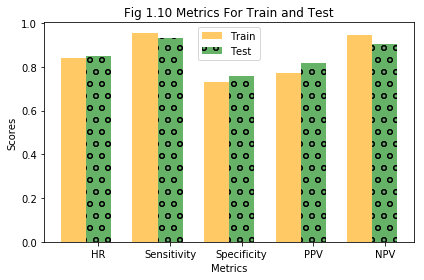

In [16]:
# data to plot
metric_count = 5
train_metrics = (train_hr, train_sens, train_spec, train_ppv,train_npv)
test_metrics = (test_hr, test_sens, test_spec, test_ppv,test_npv) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
bar_width = 0.35
opacity = 0.6
rects1 = plt.bar(index, train_metrics, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Train')
 
rects2 = plt.bar(index + bar_width, test_metrics, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Test',hatch='o')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Fig 1.10 Metrics For Train and Test')
plt.xticks(index + bar_width, ('HR', 'Sensitivity', 'Specificity', 'PPV','NPV'))
plt.legend()
plt.tight_layout()
plt.show()

## Plotting decision boundary for perceptron

[-0.019999999999999997, 0.06887357735158724, 0.41090912008567854]
[-0.019999999999999997, 0.07303783232616995, 2.398237731314878]


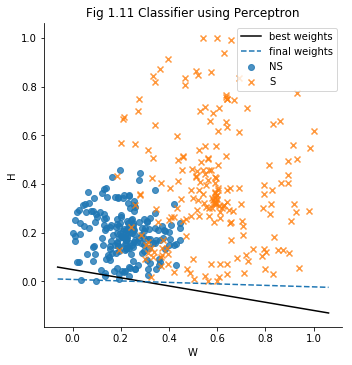

In [19]:
col_names =  ['W', 'H', 'Lbl']
df_scale  = pd.DataFrame(columns = col_names)
df_scale['W']=X_df['W']
df_scale['H']=X_df['H']
df_scale['Lbl']=df['Lbl']
import seaborn as sns
sns.lmplot('W', 'H', df_scale, hue='Lbl', fit_reg=False,legend=False,markers=["o", "x"])
fig = plt.gcf()
fig.set_size_inches(5, 5)


weights_best=perc_results['weights'][8]
print(weights_best)
wi0=weights_best[0]
wi1=weights_best[1]
wi2=weights_best[2]

a=(wi1/wi2)
b=(wi0/wi2)

print(weights_final)
wi0_f=weights_final[0]
wi1_f=weights_final[1]
wi2_f=weights_final[2]

a_f=(wi1_f/wi2_f)
b_f=(wi0_f/wi2_f)

xmin, xmax = plt.xlim()

xx = np.linspace(xmin, xmax)
yy = -(a * xx) - b
yy1= -(a_f * xx) - b_f
# Plot the hyperplane

plt.plot(xx, yy, 'k-',label='best weights')

plt.plot(xx, yy1, linestyle='--',label='final weights')
plt.title('Fig 1.11 Classifier using Perceptron')
plt.legend(loc='upper right')
plt.show()

## Custom functions to implement the KNN classifier

In [20]:
def calDistance(d1,d2,distType):
    d=0
    if distType=='Manhattan':
        d= sum([abs(a - b) for a, b in zip(d1, d2)])
    elif distType=='Euclidean':
        d= math.sqrt(sum([(a - b) ** 2 for a, b in zip(d1, d2)]))
    elif distType=='Chebyshev':
        d= max([abs(a - b) for a, b in zip(d1, d2)])
    else:
        d= math.sqrt(sum([(a - b) ** 2 for a, b in zip(d1, d2)]))
    return d
   
def kNN(X_train, y_train, X_test, k, distType, weight):
    pred_results=[]
    for i in range(len(X_test)):
        distances = []
        targets   = []
        for j in range(len(X_train)):
            dist=calDistance(X_test.iloc[i],X_train.iloc[j],distType)
            distances.append([dist, j])
        distances = sorted(distances)
        
        tmp_l=[]
        for h in range(k):
            tmp_indx = distances[h][1]
            if distances[h][0]!=0:
                tmp_l.append([1/((distances[h][0])**2),tmp_indx])
            else:
                tmp_resp=y_train[tmp_indx]
            targets.append(y_train[tmp_indx])
        
        
        if weight=='weightedKNN':
            if len(tmp_l)!=0:
                tmp_l_sort=sorted(tmp_l)
                tmp_resp=y_train[tmp_l_sort[0][1]]     
        else:
            if len(targets)==0:
                tmp_resp=0
            else:
                tmp_resp=max(set(targets), key=targets.count)
                
        pred_results.append(tmp_resp)

    return pred_results

## Finding best possible options set for KNN 

In [21]:
diff_dist=['Manhattan','Euclidean','Chebyshev']
test_err_rate_KNN_dist=[]
for dis in diff_dist:
    test_err_rate_KNN=[]
    for k in range(1,51):
        tmp_err_rate=[]
        tmp_err_rate_1=[]
        for i in range(5):
            X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_df, y, test_size=0.2, random_state=i)
            knn_pred_latest_nw=kNN(X_train_knn, y_train_knn, X_test_knn, k, dis,'normalKNN')
            knn_pred_latest_w=kNN(X_train_knn, y_train_knn, X_test_knn, k, dis,'weightedKNN')
            tmp_err_rate.append(1-hit_rate(create_conf_matrix(y_test_knn,knn_pred_latest_nw,2)))
            tmp_err_rate_1.append(1-hit_rate(create_conf_matrix(y_test_knn,knn_pred_latest_w,2)))
        test_err_rate_KNN.append([mean(tmp_err_rate), mean(tmp_err_rate_1)])
    test_err_rate_KNN_dist.append(test_err_rate_KNN)

In [24]:
norm_knnlist=[]
weig_knnlist=[]
for i in range(len(test_err_rate_KNN_dist)):
    tmp1=[]
    tmp2=[]
    for j in range(len(test_err_rate_KNN_dist[i])):
        tmp1.append(test_err_rate_KNN_dist[i][j][0])
        tmp2.append(test_err_rate_KNN_dist[i][j][1])
    norm_knnlist.append(tmp1)
    weig_knnlist.append(tmp2)


## Plotting Error rate vs K values for different types of distances and versions of knn

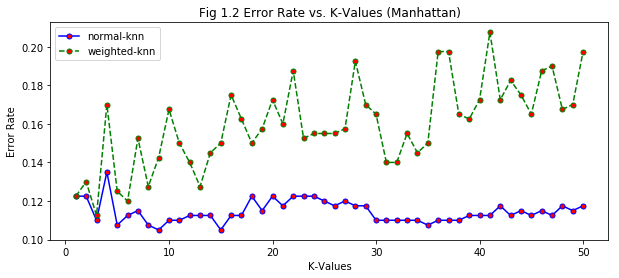

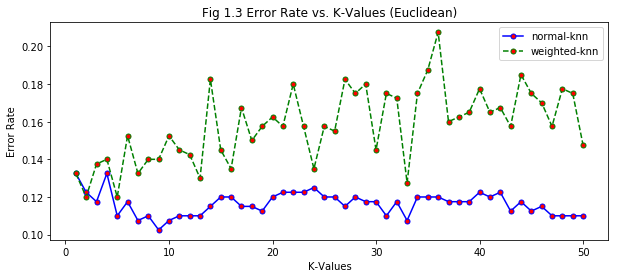

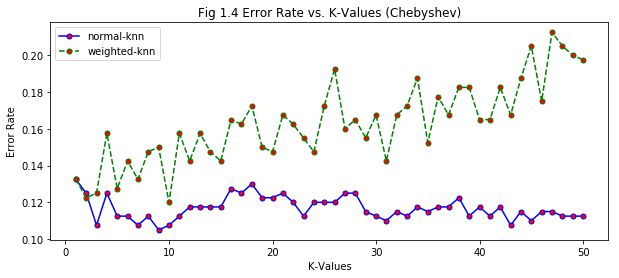

In [44]:
for i in range(len(test_err_rate_KNN_dist)):
    plt.figure(figsize=(10,4))
    plt.plot(range(1,51), norm_knnlist[i], color='blue', marker='o', markerfacecolor='red', markersize=5,label='normal-knn')
    plt.plot(range(1,51), weig_knnlist[i], color='green', linestyle='dashed', marker='o', markerfacecolor='red', markersize=5,label='weighted-knn')
    plt.legend()
    plt.title('Fig 1.'+str(i+3)+' Error Rate vs. K-Values ('+str(diff_dist[i])+')')
    plt.xlabel('K-Values')
    plt.ylabel('Error Rate')

## Plotting Error rate vs K values for different types of distances


Text(0,0.5,'Error Rate')

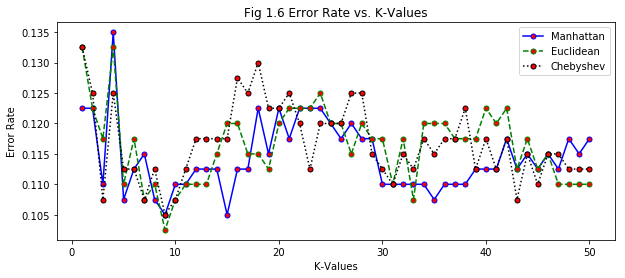

In [46]:
#for i in range(len(test_err_rate_KNN_dist)):
plt.figure(figsize=(10,4))
plt.plot(range(1,51), norm_knnlist[0], color='blue', marker='o', markerfacecolor='red', markersize=5,label='Manhattan')
plt.plot(range(1,51), norm_knnlist[1], color='green', linestyle='dashed', marker='o', markerfacecolor='red', markersize=5,label='Euclidean')
plt.plot(range(1,51), norm_knnlist[2], color='black', linestyle='dotted', marker='o', markerfacecolor='red', markersize=5,label='Chebyshev')

plt.legend()
plt.title('Fig 1.6 Error Rate vs. K-Values')
plt.xlabel('K-Values')
plt.ylabel('Error Rate')

## Finding final prediction for KNN with 9 nearest neighbours

In [7]:
from sklearn.model_selection import train_test_split
X_train_knn_fin, X_test_knn_fin, y_train_knn_fin, y_test_knn_fin = train_test_split(X_df, y, test_size=0.2, random_state=5)
knn_9_results=kNN(X_train_knn_fin, y_train_knn_fin, X_test_knn_fin, 9, 'Euclidean','normalKNN')

In [25]:
KNN9_test_conf_mat_final=create_conf_matrix(y_test_knn_fin,knn_9_results,2)
KNN9_test_hr=hit_rate(KNN9_test_conf_mat_final)
KNN9_test_sens=sensitivity(KNN9_test_conf_mat_final)
KNN9_test_spec=specificity(KNN9_test_conf_mat_final)
KNN9_test_ppv=PPV(KNN9_test_conf_mat_final)
KNN9_test_npv=NPV(KNN9_test_conf_mat_final)

## Plotting 5 metrics for best KNN

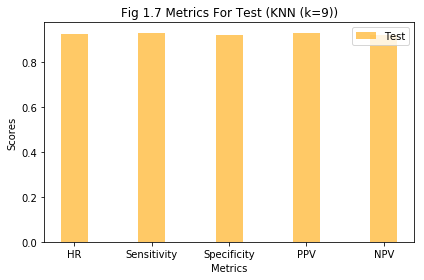

In [27]:
# data to plot
metric_count = 5
KNN_test_metrics = (KNN9_test_hr, KNN9_test_sens, KNN9_test_spec, KNN9_test_ppv,KNN9_test_npv) 
# create plot
fig, ax = plt.subplots()
index = np.arange(metric_count)
opacity = 0.6
rects1 = plt.bar(index, KNN_test_metrics, bar_width,
                 alpha=opacity,
                 color='orange',
                 label='Test')
 

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Fig 1.7 Metrics For Test (KNN (k=9))')
plt.xticks(index, ('HR', 'Sensitivity', 'Specificity', 'PPV','NPV'))
plt.legend()
plt.tight_layout()
plt.show()

## Plotting decision boundary for KNN with 9 nearest neighbours

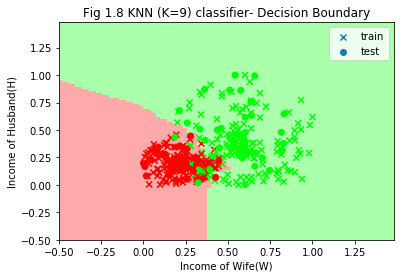

In [29]:
from matplotlib.colors import ListedColormap

k_final=9
h = .02  # step size in the mesh
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_df, y, test_size=0.2, random_state=5)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_df.iloc[:, 0].min()-0.5 , X_df.iloc[:, 0].max()+0.5
y_min, y_max = X_df.iloc[:, 1].min()-0.5 , X_df.iloc[:, 1].max()+0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
#Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
mesh_test_df=pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
Z=kNN(X_train_knn, y_train_knn, mesh_test_df, k_final, 'Euclidean','normalKNN')

Z=np.asarray(Z)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
# Plot also the training points
plt.scatter(X_train_knn.iloc[:, 0], X_train_knn.iloc[:, 1], c=y_train_knn,cmap=cmap_bold,marker='x',label='train')
plt.scatter(X_test_knn.iloc[:, 0], X_test_knn.iloc[:, 1], c=y_test_knn,cmap=cmap_bold,marker='o',label='test')
plt.legend()
plt.xlabel('Income of Wife(W)')
plt.ylabel('Income of Husband(H)')
plt.title('Fig 1.8 KNN (K=9) classifier- Decision Boundary')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()